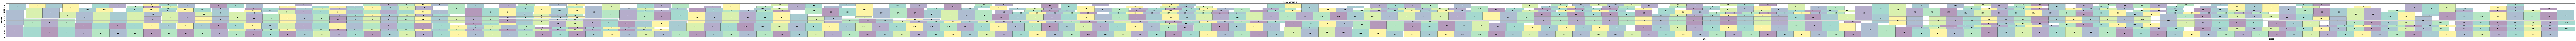

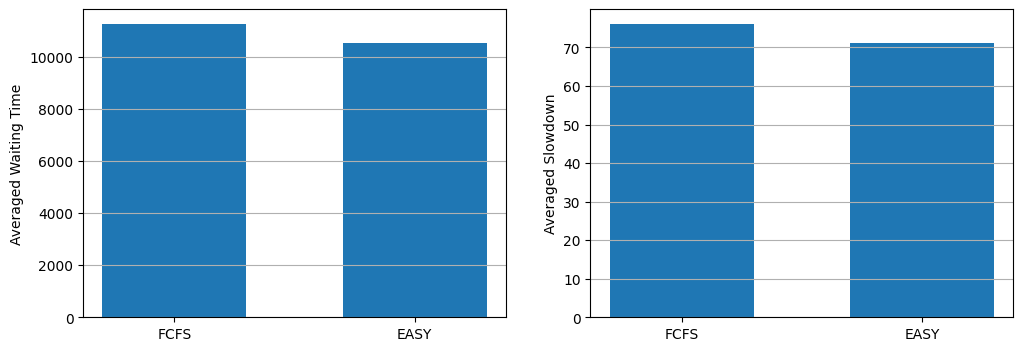

In [74]:
import matplotlib.pyplot as plt
from evalys.jobset import JobSet, ProcSet
from evalys.visu.legacy import plot_gantt
import pandas as pd

def visualize_avg_waiting_time(sim_fcfs, sim_easy):
    sim_fcfs['name'], sim_easy['name'] = "FCFS", "EASY"
    benchmark = pd.concat([sim_fcfs, sim_easy], ignore_index=True)

    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.bar('name', 'mean_waiting_time', data=benchmark, width=0.6)
    plt.grid(axis='y')
    plt.ylabel("Averaged Waiting Time")

    plt.subplot(1, 2, 2)
    plt.bar('name', 'mean_slowdown', data=benchmark, width=0.6)
    plt.grid(axis='y')
    plt.ylabel("Averaged Slowdown")

    plt.show()
    
def visualize_schedule(jobs_fcfs, jobs_easy):

    _, ax_list = plt.subplots(1, 1, figsize=(300, 4))
    # plot_gantt(jobs_fcfs, ax=ax_list[0], title="FCFS Scheduler")
    plot_gantt(jobs_easy, ax=ax_list, title="EASY Scheduler")

    plt.ylim(ymin=0, ymax=16)
    plt.yticks(list(range(16)))
    plt.savefig('plt/batsim/easy.png')
    plt.show()


jobs_fcfs = pd.read_csv('results/batsim/fcfs_jobs.csv')
jobs_fcfs['job_id'] = jobs_fcfs['job_id'].astype(str)  
jobs_fcfs['profile'] = jobs_fcfs['profile'].astype(str)
jobs_fcfs = pd.DataFrame(jobs_fcfs)
jobs_fcfs['allocated_resources'] = jobs_fcfs['allocated_resources'].apply(lambda x: ProcSet.from_str(x))
jobs_fcfs = JobSet(jobs_fcfs)


jobs_easy = pd.read_csv('results/batsim/easy_jobs.csv')
jobs_easy['job_id'] = jobs_easy['job_id'].astype(str)
jobs_easy['profile'] = jobs_easy['profile'].astype(str) 
jobs_easy = pd.DataFrame(jobs_easy)
jobs_easy['allocated_resources'] = jobs_easy['allocated_resources'].apply(lambda x: ProcSet.from_str(x))
jobs_easy = JobSet(jobs_easy)

sim_fcfs = pd.read_csv('results/batsim/fcfs_sims.csv')
sim_fcfs = pd.DataFrame(sim_fcfs)

sim_easy = pd.read_csv('results/batsim/easy_sims.csv')
sim_easy = pd.DataFrame(sim_easy)

visualize_schedule(jobs_fcfs, jobs_easy)
visualize_avg_waiting_time(sim_fcfs, sim_easy)

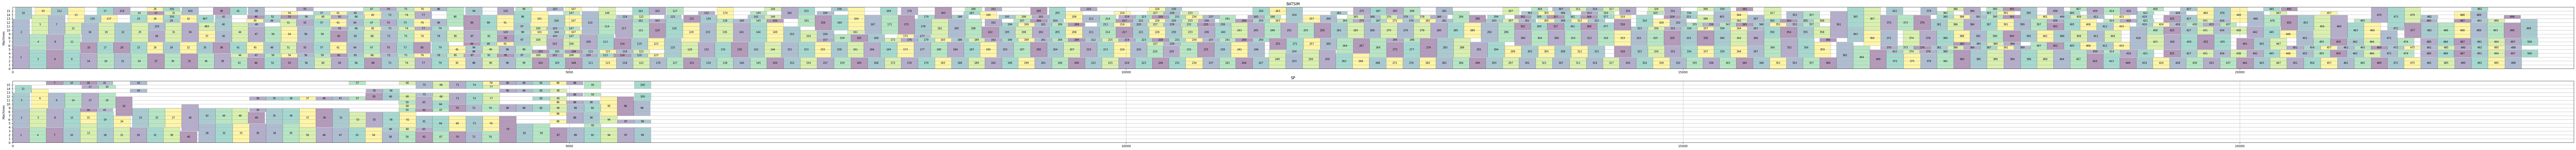

In [49]:
import matplotlib.pyplot as plt
from evalys.jobset import JobSet, ProcSet
from evalys.visu.legacy import plot_gantt
import pandas as pd

def visualize_avg_waiting_time(jobs_f, sim_f, jobs_e, sim_e):
    fcfs, easy = jobs_f.to_dataframe(), jobs_e.to_dataframe()

    fcfs, easy = JobSet(fcfs), JobSet(easy)

    fcfs, easy = sim_f.to_dataframe(), sim_e.to_dataframe()
    fcfs['name'], easy['name'] = "FCFS", "EASY"
    benchmark = pd.concat([fcfs, easy], ignore_index=True)

    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.bar('name', 'mean_waiting_time', data=benchmark, width=0.6)
    plt.grid(axis='y')
    plt.ylabel("Averaged Waiting Time")

    plt.subplot(1, 2, 2)
    plt.bar('name', 'mean_slowdown', data=benchmark, width=0.6)
    plt.grid(axis='y')
    plt.ylabel("Averaged Slowdown")

    plt.show()
    
def visualize_schedule(jobs_easy_batsim, jobs_easy_sp):

    _, ax_list = plt.subplots(nrows=2, ncols=1, figsize=(150, 8))
    # plot_gantt(jobs_fcfs, ax=ax_list[0], title="FCFS")
    plot_gantt(jobs_easy_batsim, ax=ax_list[0], title="BATSIM")
    plot_gantt(jobs_easy_sp, ax=ax_list[1], title="SP")
    
    ax_list[0].set_ylim(0, 16)
    ax_list[1].set_ylim(0, 16)
    ax_list[0].set_xlim(0, 23000)
    ax_list[1].set_xlim(0, 23000)
    ax_list[0].set_yticks(range(16))
    ax_list[1].set_yticks(range(16))

    plt.savefig('plt/comparison/easy.png')
    plt.show()

jobs_easy_batsim = pd.read_csv('results/batsim/easy_jobs.csv')
jobs_easy_batsim['job_id'] = jobs_easy_batsim['job_id'].astype(str)
jobs_easy_batsim['profile'] = jobs_easy_batsim['profile'].astype(str) 
jobs_easy_batsim = pd.DataFrame(jobs_easy_batsim)
jobs_easy_batsim['allocated_resources'] = jobs_easy_batsim['allocated_resources'].apply(lambda x: ProcSet.from_str(x))
jobs_easy_batsim = JobSet(jobs_easy_batsim)

jobs_easy_sp = pd.read_csv('results/sp/easy_jobs.csv')
jobs_easy_sp['job_id'] = jobs_easy_sp['job_id'].astype(str)  
jobs_easy_sp['profile'] = jobs_easy_sp['profile'].astype(str)
jobs_easy_sp = pd.DataFrame(jobs_easy_sp)
jobs_easy_sp['allocated_resources'] = jobs_easy_sp['allocated_resources'].apply(lambda x: ProcSet.from_str(x))
jobs_easy_sp = JobSet(jobs_easy_sp)

visualize_schedule(jobs_easy_batsim, jobs_easy_sp)

In [64]:
# compare jobs monitor
import pandas as pd
from IPython.display import display

# Read CSV files
jobs_easy_batsim = pd.read_csv('results/batsim/easy_jobs_t30.csv')
jobs_easy_sp = pd.read_csv('results/sp/easy_jobs_t30.csv')

# Sort by job_id
jobs_easy_batsim = jobs_easy_batsim.sort_values(by='job_id', ascending=True).reset_index(drop=True)
jobs_easy_sp = jobs_easy_sp.sort_values(by='job_id', ascending=True).reset_index(drop=True)

# Calculate execution time differences
execution_time_diff = jobs_easy_batsim['execution_time'] - jobs_easy_sp['execution_time']
start_time_diff = jobs_easy_batsim['starting_time'] - jobs_easy_sp['starting_time']
finish_time_diff = jobs_easy_batsim['finish_time'] - jobs_easy_sp['finish_time']

def expand_ranges(input_str):
    parts = input_str.split()
    result = []

    for part in parts:
        if '-' in part:
            start, end = map(int, part.split('-'))
            result.extend(str(i) for i in range(start, end + 1))
        else:
            result.append(part)

    result = sorted(result)
    return ' '.join(result)

same_node_used = jobs_easy_batsim['allocated_resources'].apply(expand_ranges) == jobs_easy_sp['allocated_resources'].apply(expand_ranges)


# Create a dataframe to display results
result_df = pd.DataFrame({
    'job_id': jobs_easy_batsim['job_id'],
    'sp_start': jobs_easy_sp['starting_time'],
    'batsim_start': jobs_easy_batsim['starting_time'],
    'sp_finish': jobs_easy_sp['finish_time'],
    'batsim_finish': jobs_easy_batsim['finish_time'],
    'start_diff': start_time_diff,
    'exec_diff': execution_time_diff,
    'finish_diff': finish_time_diff,
    'same_node_used': same_node_used,
    "batsim_node_used": jobs_easy_batsim['allocated_resources'],
    "sp_node_used": jobs_easy_sp['allocated_resources']
})

# Display the dataframe in Jupyter Notebook
display(result_df)


,job_id,sp_start,batsim_start,sp_finish,batsim_finish,start_diff,exec_diff,finish_diff,same_node_used,batsim_node_used,sp_node_used
0,1,2.0,2.0,151.0,151.0,0.0,0.0,0.0,True,0-3,0 1 2 3
1,2,3.0,3.0,153.0,153.0,0.0,0.0,0.0,True,4-8,4 5 6 7 8
2,3,4.0,4.0,154.0,154.0,0.0,0.0,0.0,True,9-12,9 10 11 12
3,4,151.0,151.0,300.0,300.0,0.0,0.0,0.0,True,0-3,0 1 2 3
4,5,153.0,153.0,304.0,304.0,0.0,0.0,0.0,True,4-8,4 5 6 7 8
...,...,...,...,...,...,...,...,...,...,...,...
95,96,4082.0,4082.0,4230.0,4230.0,0.0,0.0,0.0,True,9 12-15,9 12 13 14 15
96,97,4085.0,4085.0,4237.0,4237.0,0.0,0.0,0.0,True,0-3 10,0 1 2 3 10
97,98,4219.0,4219.0,4367.0,4367.0,0.0,0.0,0.0,True,4-7,4 5 6 7
98,99,4235.0,4235.0,4384.0,4384.0,0.0,0.0,0.0,True,8-9 11-13,8 9 11 12 13


In [69]:
import pandas as pd
from IPython.display import display

# Read the CSV files
jobs_easy_batsim = pd.read_csv('results/batsim/easy_host_t30.csv')
jobs_easy_sp = pd.read_csv('results/sp/easy_host_t30.csv')

# Sort by 'time' to ensure the data aligns for comparison
jobs_easy_batsim = jobs_easy_batsim.sort_values(by='time', ascending=True).reset_index(drop=True)
jobs_easy_sp = jobs_easy_sp.sort_values(by='time', ascending=True).reset_index(drop=True)

# Create a new dataframe with the time column and the difference for each column you want to compare
columns_to_compare = ['sleeping', 'switching_on', 'switching_off', 'idle', 'computing']

result_df = pd.DataFrame({
    'time': jobs_easy_batsim['time']
})

# Loop through the columns to create the differences
for col in columns_to_compare:
    result_df[f'{col}_diff'] = jobs_easy_batsim[f'nb_{col}'] - jobs_easy_sp[col]

# Optionally, display the result
display(result_df)

# Save the result to a CSV file if needed
# result_df.to_csv('comparison_result.csv', index=False)


,time,sleeping_diff,switching_on_diff,switching_off_diff,idle_diff,computing_diff
0,0,0,0,0,0,0
1,2,0,0,0,0,0
2,3,0,0,0,0,0
3,4,0,0,0,0,0
4,21,0,0,0,0,0
...,...,...,...,...,...,...
135,4402,0,0,0,0,0
136,4414,0,0,0,0,0
137,4416,0,0,0,0,0
138,4419,0,0,0,0,0


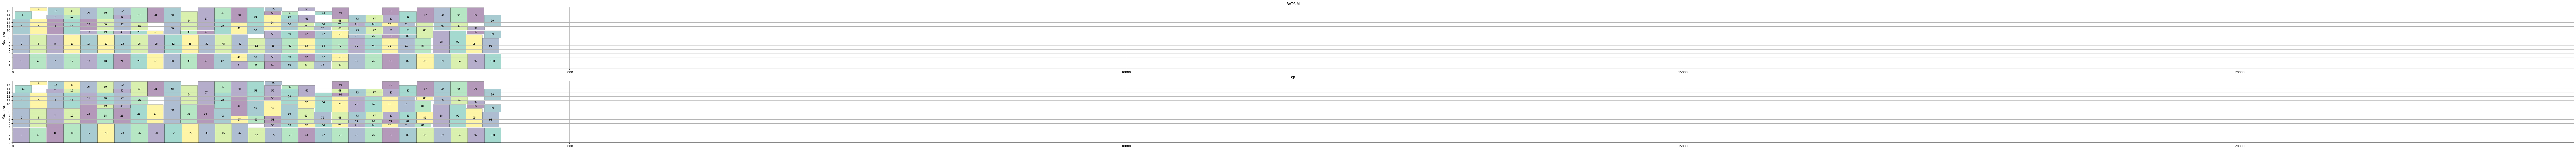

In [70]:
import matplotlib.pyplot as plt
from evalys.jobset import JobSet, ProcSet
from evalys.visu.legacy import plot_gantt
import pandas as pd

def visualize_avg_waiting_time(jobs_f, sim_f, jobs_e, sim_e):
    fcfs, easy = jobs_f.to_dataframe(), jobs_e.to_dataframe()

    fcfs, easy = JobSet(fcfs), JobSet(easy)

    fcfs, easy = sim_f.to_dataframe(), sim_e.to_dataframe()
    fcfs['name'], easy['name'] = "FCFS", "EASY"
    benchmark = pd.concat([fcfs, easy], ignore_index=True)

    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.bar('name', 'mean_waiting_time', data=benchmark, width=0.6)
    plt.grid(axis='y')
    plt.ylabel("Averaged Waiting Time")

    plt.subplot(1, 2, 2)
    plt.bar('name', 'mean_slowdown', data=benchmark, width=0.6)
    plt.grid(axis='y')
    plt.ylabel("Averaged Slowdown")

    plt.show()
    
def visualize_schedule(jobs_easy_batsim, jobs_easy_sp):

    _, ax_list = plt.subplots(nrows=2, ncols=1, figsize=(150, 8))
    # plot_gantt(jobs_fcfs, ax=ax_list[0], title="FCFS")
    plot_gantt(jobs_easy_batsim, ax=ax_list[0], title="BATSIM")
    plot_gantt(jobs_easy_sp, ax=ax_list[1], title="SP")
    
    ax_list[0].set_ylim(0, 16)
    ax_list[1].set_ylim(0, 16)
    ax_list[0].set_xlim(0, 23000)
    ax_list[1].set_xlim(0, 23000)
    ax_list[0].set_yticks(range(16))
    ax_list[1].set_yticks(range(16))

    plt.savefig('plt/comparison/easy.png')
    plt.show()

jobs_easy_batsim = pd.read_csv('results/batsim/easy_jobs_t30.csv')
jobs_easy_batsim['job_id'] = jobs_easy_batsim['job_id'].astype(str)
jobs_easy_batsim['profile'] = jobs_easy_batsim['profile'].astype(str) 
jobs_easy_batsim = pd.DataFrame(jobs_easy_batsim)
jobs_easy_batsim['allocated_resources'] = jobs_easy_batsim['allocated_resources'].apply(lambda x: ProcSet.from_str(x))
jobs_easy_batsim = JobSet(jobs_easy_batsim)

jobs_easy_sp = pd.read_csv('results/sp/easy_jobs_t30.csv')
jobs_easy_sp['job_id'] = jobs_easy_sp['job_id'].astype(str)  
jobs_easy_sp['profile'] = jobs_easy_sp['profile'].astype(str)
jobs_easy_sp = pd.DataFrame(jobs_easy_sp)
jobs_easy_sp['allocated_resources'] = jobs_easy_sp['allocated_resources'].apply(lambda x: ProcSet.from_str(x))
jobs_easy_sp = JobSet(jobs_easy_sp)

visualize_schedule(jobs_easy_batsim, jobs_easy_sp)

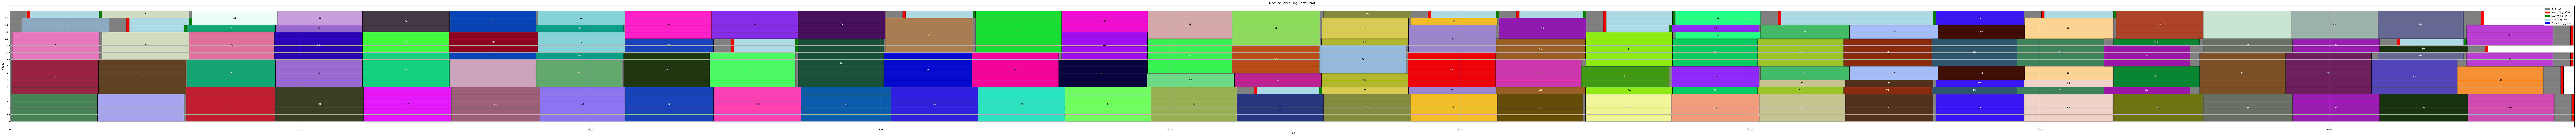

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

# Data parsing (using pandas to read CSV)
data = pd.read_csv('results/sp/easy_nodes_t30.csv')

# Prepare data structures
all_nodes = set()
timeline = []

# Process data and find all unique nodes
for index, row in data.iterrows():
    nodes = list(map(int, row['allocated_resources'].split()))  # Adjust the column name as needed
    all_nodes.update(nodes)
    timeline.append({
        'starting_time': float(row['starting_time']),  # Adjust the column name as needed
        'finish_time': float(row['finish_time']),  # Adjust the column name as needed
        'allocated_resources': nodes,
        'type': row['type'],  # Adjust the column name as needed
        'job_id': int(row['job_id'])  # Adjust the column name as needed
    })

# Create figure
fig, ax = plt.subplots(figsize=(150, 8))
max_time = max([ev['finish_time'] for ev in timeline])
max_node = max(all_nodes)

# Color mapping
colors = {
    -1: 'gray',        # Idle
    -2: 'red',         # Switching Off
    -3: 'green',       # Switching On
    -4: 'lightblue'    # Sleeping
}

# Define a unique color for each computing job
job_colors = {}

# Plot each event
for event in timeline:
    nodes = sorted(event['allocated_resources'])
    groups = []
    while nodes:
        start = nodes[0]
        end = start
        while nodes and nodes[0] == end:
            end += 1
            nodes.pop(0)
        groups.append((start, end - start))
    
    for y, height in groups:
        # Ensure predefined colors are used
        if event['job_id'] in colors:
            color = colors[event['job_id']]
        else:
            # Get the color for the job_id, or assign a new one if it's not in job_colors
            if event['job_id'] not in job_colors:
                job_colors[event['job_id']] = np.random.rand(3,)
            color = job_colors[event['job_id']]
        
        ax.broken_barh([(event['starting_time'], event['finish_time'] - event['starting_time'])], 
                      (y, height), facecolors=color, edgecolor='black')
        
        if event['job_id'] > 0:
            ax.text((event['starting_time'] + event['finish_time'])/2, y + height/2, 
                    str(event['job_id']), ha='center', va='center',
                    color='white' if np.mean(color) < 0.5 else 'black')

# Configure plot
ax.set_xlabel('Time')
ax.set_ylabel('Nodes')
ax.set_yticks(range(16))
ax.set_yticklabels(range(16))
ax.set_xlim(0, max_time)
ax.grid(True)

# Create legend
legend_patches = [
    mpatches.Patch(color='gray', label='Idle (-1)'),
    mpatches.Patch(color='red', label='Switching Off (-2)'),
    mpatches.Patch(color='green', label='Switching On (-3)'),
    mpatches.Patch(color='lightblue', label='Sleeping (-4)'),
    mpatches.Patch(color='blue', label='Computing Jobs')
]
ax.legend(handles=legend_patches, loc='upper right')

plt.title('Machine Scheduling Gantt Chart')
plt.tight_layout()
plt.show()

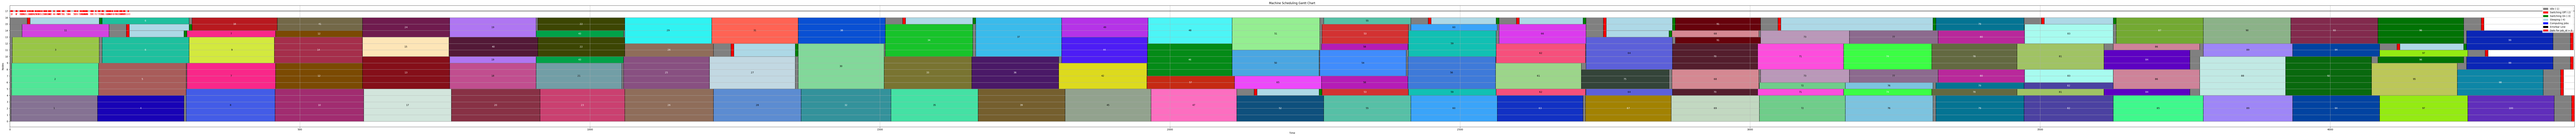

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

# Data parsing (using pandas to read CSV)
data = pd.read_csv('results/sp/easy_nodes_t30.csv')

# Prepare data structures
all_nodes = set()
timeline = []

# Process data and find all unique nodes
for index, row in data.iterrows():
    nodes = list(map(int, row['allocated_resources'].split()))  # Adjust the column name as needed
    all_nodes.update(nodes)
    timeline.append({
        'submission_time': float(row['submission_time']),  # Adjust the column name as needed
        'starting_time': float(row['starting_time']),  # Adjust the column name as needed
        'finish_time': float(row['finish_time']),  # Adjust the column name as needed
        'allocated_resources': nodes,
        'type': row['type'],  # Adjust the column name as needed
        'job_id': int(row['job_id'])  # Adjust the column name as needed
    })

# Create figure
fig, ax = plt.subplots(figsize=(150, 8))
max_time = max([ev['finish_time'] for ev in timeline])
max_node = max(all_nodes)

# Color mapping
colors = {
    -1: 'gray',        # Idle
    -2: 'red',         # Switching Off
    -3: 'green',       # Switching On
    -4: 'lightblue'    # Sleeping
}

# Define a unique color for each computing job
job_colors = {}

# Plot each event
for event in timeline:
    nodes = sorted(event['allocated_resources'])
    groups = []
    while nodes:
        start = nodes[0]
        end = start
        while nodes and nodes[0] == end:
            end += 1
            nodes.pop(0)
        groups.append((start, end - start))
    
    for y, height in groups:
        # Ensure predefined colors are used
        if event['job_id'] in colors:
            color = colors[event['job_id']]
        else:
            # Get the color for the job_id, or assign a new one if it's not in job_colors
            if event['job_id'] not in job_colors:
                job_colors[event['job_id']] = np.random.rand(3,)
            color = job_colors[event['job_id']]
        
        ax.broken_barh([(event['starting_time'], event['finish_time'] - event['starting_time'])], 
                      (y, height), facecolors=color, edgecolor='black')
        
        if event['job_id'] > 0:
            ax.text((event['starting_time'] + event['finish_time'])/2, y + height/2, 
                    str(event['job_id']), ha='center', va='center',
                    color='white' if np.mean(color) < 0.5 else 'black')

# Add errorbar-like horizontal line at Y=17 ranging from 0 to 10000
ax.errorbar(x=[5000], y=[17], xerr=5000, fmt='-', color='black')

# Add dots at specific times only when job_id > 0, with job_id below the dot
for event in timeline:
    if event['job_id'] > 0:
        ax.plot(event['submission_time'], 17, 'ro')
        ax.text(event['submission_time'], 16.5, str(event['job_id']), ha='center', va='center', color='red')

# Configure plot
ax.set_xlabel('Time')
ax.set_ylabel('Nodes')
ax.set_yticks(range(18))
ax.set_yticklabels(range(18))
ax.set_xlim(0, max_time)
ax.grid(True)

# Create legend
legend_patches = [
    mpatches.Patch(color='gray', label='Idle (-1)'),
    mpatches.Patch(color='red', label='Switching Off (-2)'),
    mpatches.Patch(color='green', label='Switching On (-3)'),
    mpatches.Patch(color='lightblue', label='Sleeping (-4)'),
    mpatches.Patch(color='blue', label='Computing Jobs'),
    mpatches.Patch(color='black', label='Errorbar Line'),
    mpatches.Patch(color='red', label='Dots for job_id > 0')
]
ax.legend(handles=legend_patches, loc='upper right')

plt.title('Machine Scheduling Gantt Chart')
plt.tight_layout()
plt.show()


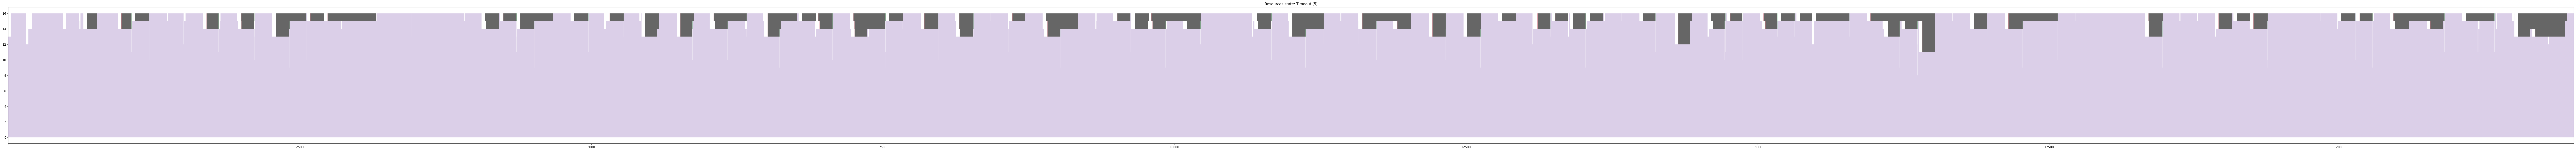

In [15]:
from evalys.mstates import MachineStatesChanges
from evalys.visu.legacy import plot_mstates

# Convert monitors to dataframes
t_5 = pd.read_csv('results/batsim/easy_host_t5.csv')
# Plot
_, ax_list = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(150, 8))

plot_mstates(t_5, ax=ax_list, title="Resources state: Timeout (5)")



# Show
plt.xlim(xmin=0, xmax=22000)
plt.show()